In [1]:
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import pandas as pd

import plotly.graph_objects as go
import numpy as np

In [3]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession 
from pyspark.conf import SparkConf
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import StringType, IntegerType, StructType, StructField

In [4]:
spark = SparkSession \
    .builder \
    .appName("regression") \
    .master("local[4]") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.network.timeout","3600")\
    .config("spark.executor.heartbeatInterval","3000s")\
    .getOrCreate()

# TREND ANALYSIS

In [31]:
df = spark.read.json('../data/cleaned_dataset')
df.show(3,truncate=False,vertical =True)


-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------
 acousticness          | 0.658                                                                                                                              
 age                   | 41.821917808219176                                                                                                                 
 avg_artist_followers  | 5403.5                                                                                                                             
 avg_artist_popularity | 40.0                                                                                                                               
 danceability          | 0.602                                                                                                                              
 duration_ms           | 156067                           

In [34]:

technical_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',  'speechiness', 'tempo', 'time_signature', 'valence']

In [33]:
df = df.withColumn('year',2021 - df.age.cast(IntegerType()))
from pyspark.sql.window import Window
windowSpec = Window.partitionBy("year") 
df = df.withColumn("popularity_norma",sum(col("popularity_track")).over(windowSpec))
df.select('year','popularity_norma').show()



+----+----------------+
|year|popularity_norma|
+----+----------------+
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
|1959|           59595|
+----+----------------+
only showing top 20 rows



In [35]:
from functools import reduce

In [67]:


dfn = reduce(
    lambda memo_df, col_name: memo_df.withColumn(col_name+'_n', (col(col_name)/col('popularity_norma'))  ),technical_columns,df)

dfn

DataFrame[acousticness: double, age: double, avg_artist_followers: double, avg_artist_popularity: double, danceability: double, duration_ms: bigint, energy: double, genres: array<string>, id_track: string, instrumentalness: double, key: bigint, liveness: double, loudness: double, mode: bigint, popularity_track: bigint, release_date: string, speechiness: double, sum_artist_followers: bigint, sum_artist_popularity: bigint, tempo: double, time_signature: bigint, valence: double, year: int, popularity_norma: bigint, acousticness_n: double, danceability_n: double, duration_ms_n: double, energy_n: double, instrumentalness_n: double, key_n: double, liveness_n: double, loudness_n: double, mode_n: double, speechiness_n: double, tempo_n: double, time_signature_n: double, valence_n: double]

In [79]:
for column in technical_columns:
    for aggr in ['min','max','avg']:
        s = "F."+aggr+"('"+column+"').alias('"+aggr+"_"+column+"'),\\"
        print(s,end='\n')
    print("F.sum('"+column+"_n').alias('wavg_"+column+"'),\\")
    

F.min('acousticness').alias('min_acousticness'),\
F.max('acousticness').alias('max_acousticness'),\
F.avg('acousticness').alias('avg_acousticness'),\
F.sum('acousticness_n').alias('wavg_acousticness'),\
F.min('danceability').alias('min_danceability'),\
F.max('danceability').alias('max_danceability'),\
F.avg('danceability').alias('avg_danceability'),\
F.sum('danceability_n').alias('wavg_danceability'),\
F.min('duration_ms').alias('min_duration_ms'),\
F.max('duration_ms').alias('max_duration_ms'),\
F.avg('duration_ms').alias('avg_duration_ms'),\
F.sum('duration_ms_n').alias('wavg_duration_ms'),\
F.min('energy').alias('min_energy'),\
F.max('energy').alias('max_energy'),\
F.avg('energy').alias('avg_energy'),\
F.sum('energy_n').alias('wavg_energy'),\
F.min('instrumentalness').alias('min_instrumentalness'),\
F.max('instrumentalness').alias('max_instrumentalness'),\
F.avg('instrumentalness').alias('avg_instrumentalness'),\
F.sum('instrumentalness_n').alias('wavg_instrumentalness'),\
F.min('ke

In [74]:
import pyspark.sql.functions as F

In [82]:

dfg = dfn.groupBy('year')\
    .agg(F.min('acousticness').alias('min_acousticness'),\
        F.max('acousticness').alias('max_acousticness'),\
        F.avg('acousticness').alias('avg_acousticness'),\
        F.sum('acousticness_n').alias('wavg_acousticness'),\
        F.min('danceability').alias('min_danceability'),\
        F.max('danceability').alias('max_danceability'),\
        F.avg('danceability').alias('avg_danceability'),\
        F.sum('danceability_n').alias('wavg_danceability'),\
        F.min('duration_ms').alias('min_duration_ms'),\
        F.max('duration_ms').alias('max_duration_ms'),\
        F.avg('duration_ms').alias('avg_duration_ms'),\
        F.sum('duration_ms_n').alias('wavg_duration_ms'),\
        F.min('energy').alias('min_energy'),\
        F.max('energy').alias('max_energy'),\
        F.avg('energy').alias('avg_energy'),\
        F.sum('energy_n').alias('wavg_energy'),\
        F.min('instrumentalness').alias('min_instrumentalness'),\
        F.max('instrumentalness').alias('max_instrumentalness'),\
        F.avg('instrumentalness').alias('avg_instrumentalness'),\
        F.sum('instrumentalness_n').alias('wavg_instrumentalness'),\
        F.min('key').alias('min_key'),\
        F.max('key').alias('max_key'),\
        F.avg('key').alias('avg_key'),\
        F.sum('key_n').alias('wavg_key'),\
        F.min('liveness').alias('min_liveness'),\
        F.max('liveness').alias('max_liveness'),\
        F.avg('liveness').alias('avg_liveness'),\
        F.sum('liveness_n').alias('wavg_liveness'),\
        F.min('loudness').alias('min_loudness'),\
        F.max('loudness').alias('max_loudness'),\
        F.avg('loudness').alias('avg_loudness'),\
        F.sum('loudness_n').alias('wavg_loudness'),\
        F.min('mode').alias('min_mode'),\
        F.max('mode').alias('max_mode'),\
        F.avg('mode').alias('avg_mode'),\
        F.sum('mode_n').alias('wavg_mode'),\
        F.min('speechiness').alias('min_speechiness'),\
        F.max('speechiness').alias('max_speechiness'),\
        F.avg('speechiness').alias('avg_speechiness'),\
        F.sum('speechiness_n').alias('wavg_speechiness'),\
        F.min('tempo').alias('min_tempo'),\
        F.max('tempo').alias('max_tempo'),\
        F.avg('tempo').alias('avg_tempo'),\
        F.sum('tempo_n').alias('wavg_tempo'),\
        F.min('time_signature').alias('min_time_signature'),\
        F.max('time_signature').alias('max_time_signature'),\
        F.avg('time_signature').alias('avg_time_signature'),\
        F.sum('time_signature_n').alias('wavg_time_signature'),\
        F.min('valence').alias('min_valence'),\
        F.max('valence').alias('max_valence'),\
        F.avg('valence').alias('avg_valence'),\
        F.sum('valence_n').alias('wavg_valence') )

In [83]:
dfg.printSchema()

root
 |-- year: integer (nullable = true)
 |-- min_acousticness: double (nullable = true)
 |-- max_acousticness: double (nullable = true)
 |-- avg_acousticness: double (nullable = true)
 |-- wavg_acousticness: double (nullable = true)
 |-- min_danceability: double (nullable = true)
 |-- max_danceability: double (nullable = true)
 |-- avg_danceability: double (nullable = true)
 |-- wavg_danceability: double (nullable = true)
 |-- min_duration_ms: long (nullable = true)
 |-- max_duration_ms: long (nullable = true)
 |-- avg_duration_ms: double (nullable = true)
 |-- wavg_duration_ms: double (nullable = true)
 |-- min_energy: double (nullable = true)
 |-- max_energy: double (nullable = true)
 |-- avg_energy: double (nullable = true)
 |-- wavg_energy: double (nullable = true)
 |-- min_instrumentalness: double (nullable = true)
 |-- max_instrumentalness: double (nullable = true)
 |-- avg_instrumentalness: double (nullable = true)
 |-- wavg_instrumentalness: double (nullable = true)
 |-- min_

In [85]:
dfg.count()

101

In [86]:
dfp = dfg.toPandas()

In [88]:
dfp.to_csv('../data/timeseries.csv')

### Design Trends

In [6]:

technical_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',  'speechiness', 'tempo', 'time_signature', 'valence']

In [46]:
dfp = pd.read_csv('../data/timeseries.csv',index_col=0)
dfp

,year,min_acousticness,max_acousticness,avg_acousticness,wavg_acousticness,min_danceability,max_danceability,avg_danceability,wavg_danceability,min_duration_ms,...,avg_tempo,wavg_tempo,min_time_signature,max_time_signature,avg_time_signature,wavg_time_signature,min_valence,max_valence,avg_valence,wavg_valence
0,1959,0.000463,0.996,0.797920,0.061161,0.0000,0.952,0.484321,0.037124,30040,...,111.872823,8.575133,0,5,3.780429,0.289773,0.0000,0.989,0.508534,0.038980
1,1990,0.000001,0.996,0.396070,0.015654,0.0000,0.985,0.557751,0.022044,30467,...,119.539611,4.724480,0,5,3.883712,0.153493,0.0000,0.990,0.571420,0.022584
2,1975,0.000005,0.996,0.497883,0.021566,0.0641,0.947,0.519428,0.022499,31280,...,117.324881,5.081937,1,5,3.848027,0.166678,0.0000,0.994,0.571237,0.024743
3,1977,0.000002,0.996,0.481638,0.019875,0.0000,0.955,0.534042,0.022038,30107,...,118.901668,4.906557,0,5,3.841072,0.158504,0.0000,1.000,0.572814,0.023638
4,1924,0.000847,0.996,0.833162,2.097936,0.0000,0.869,0.628769,1.583265,97493,...,113.414818,285.583188,0,5,3.650972,9.193299,0.0000,0.977,0.610186,1.536475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1929,0.121000,0.996,0.954023,2.740964,0.0912,0.937,0.605083,1.738437,62212,...,118.917433,341.656562,1,5,3.862038,11.095855,0.0338,0.973,0.648447,1.863024
97,1928,0.000131,0.996,0.940836,0.640233,0.0650,0.901,0.541183,0.368272,34133,...,109.107917,74.247264,1,5,3.816401,2.597037,0.0324,0.976,0.522406,0.355494
98,1933,0.004040,0.996,0.830922,0.255883,0.0623,0.920,0.591387,0.182118,57980,...,112.571244,34.666347,1,5,3.783472,1.165121,0.0340,0.979,0.599417,0.184591
99,2021,0.000001,0.996,0.270236,0.007147,0.0000,0.987,0.662397,0.017518,23493,...,121.818194,3.221681,0,5,3.944104,0.104308,0.0000,0.986,0.500156,0.013227


In [47]:
dfp = dfp[dfp.year>1971]
dfp.set_index('year',inplace = True,drop=True)
dfp.sort_index(inplace=True)


C:\Users\carlo\anaconda3\envs\pyspark_env\lib\site-packages\pandas\core\frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,


In [48]:
dfp

,min_acousticness,max_acousticness,avg_acousticness,wavg_acousticness,min_danceability,max_danceability,avg_danceability,wavg_danceability,min_duration_ms,max_duration_ms,...,avg_tempo,wavg_tempo,min_time_signature,max_time_signature,avg_time_signature,wavg_time_signature,min_valence,max_valence,avg_valence,wavg_valence
year,,,,,,,,,,,,,,,,,,,,,
1972,0.000007,0.996,0.546940,0.022653,0.0000,0.921,0.513294,0.021259,31453,4142067,...,116.609066,4.829645,0,5,3.832303,0.158724,0.00000,0.988,0.577270,0.023909
1973,0.000004,0.996,0.514682,0.020233,0.0000,0.942,0.518486,0.020383,14708,2052573,...,116.818559,4.592344,0,5,3.850962,0.151388,0.00000,0.989,0.574577,0.022588
1974,0.000003,0.996,0.522935,0.022950,0.0000,0.946,0.517479,0.022711,30067,3153173,...,117.329357,5.149287,0,5,3.848920,0.168919,0.00000,0.992,0.580689,0.025485
1975,0.000005,0.996,0.497883,0.021566,0.0641,0.947,0.519428,0.022499,31280,3091707,...,117.324881,5.081937,1,5,3.848027,0.166678,0.00000,0.994,0.571237,0.024743
1976,0.000004,0.995,0.488774,0.019993,0.0717,0.944,0.523765,0.021424,30667,3377907,...,117.723843,4.815341,0,5,3.864226,0.158061,0.02420,0.994,0.582466,0.023825
1977,0.000002,0.996,0.481638,0.019875,0.0000,0.955,0.534042,0.022038,30107,1750875,...,118.901668,4.906557,0,5,3.841072,0.158504,0.00000,1.000,0.572814,0.023638
1978,0.000000,0.996,0.447950,0.018282,0.0000,0.956,0.532305,0.021724,31265,3441840,...,118.763320,4.846925,0,5,3.867481,0.157838,0.00000,1.000,0.592228,0.024170
1979,0.000000,0.996,0.438439,0.016892,0.0000,0.947,0.564431,0.021746,30400,5621218,...,118.003438,4.546380,0,5,3.853822,0.148478,0.00000,0.997,0.610295,0.023513
1980,0.000007,0.996,0.431627,0.017210,0.0000,0.961,0.559924,0.022325,30120,2796951,...,118.994062,4.744577,0,5,3.832373,0.152806,0.00000,0.991,0.595041,0.023726


In [49]:
index = pd.date_range(end='2021', periods=100,freq='Y')
index

DatetimeIndex(['1921-12-31', '1922-12-31', '1923-12-31', '1924-12-31',
               '1925-12-31', '1926-12-31', '1927-12-31', '1928-12-31',
               '1929-12-31', '1930-12-31', '1931-12-31', '1932-12-31',
               '1933-12-31', '1934-12-31', '1935-12-31', '1936-12-31',
               '1937-12-31', '1938-12-31', '1939-12-31', '1940-12-31',
               '1941-12-31', '1942-12-31', '1943-12-31', '1944-12-31',
               '1945-12-31', '1946-12-31', '1947-12-31', '1948-12-31',
               '1949-12-31', '1950-12-31', '1951-12-31', '1952-12-31',
               '1953-12-31', '1954-12-31', '1955-12-31', '1956-12-31',
               '1957-12-31', '1958-12-31', '1959-12-31', '1960-12-31',
               '1961-12-31', '1962-12-31', '1963-12-31', '1964-12-31',
               '1965-12-31', '1966-12-31', '1967-12-31', '1968-12-31',
               '1969-12-31', '1970-12-31', '1971-12-31', '1972-12-31',
               '1973-12-31', '1974-12-31', '1975-12-31', '1976-12-31',
      

In [53]:
dfp['min_'+col]

year
1972    0.000007
1973    0.000004
1974    0.000003
1975    0.000005
1976    0.000004
1977    0.000002
1978    0.000000
1979    0.000000
1980    0.000007
1981    0.000003
1982    0.000002
1983    0.000001
1984    0.000000
1985    0.000001
1986    0.000001
1987    0.000000
1988    0.000001
1989    0.000001
1990    0.000001
1991    0.000001
1992    0.000000
1993    0.000001
1994    0.000001
1995    0.000001
1996    0.000000
1997    0.000001
1998    0.000001
1999    0.000001
2000    0.000000
2001    0.000002
2002    0.000000
2003    0.000001
2004    0.000001
2005    0.000000
2006    0.000000
2007    0.000000
2008    0.000001
2009    0.000001
2010    0.000002
2011    0.000001
2012    0.000000
2013    0.000001
2014    0.000001
2015    0.000000
2016    0.000000
2017    0.000000
2018    0.000000
2019    0.000000
2020    0.000000
2021    0.000001
Name: min_acousticness, dtype: float64

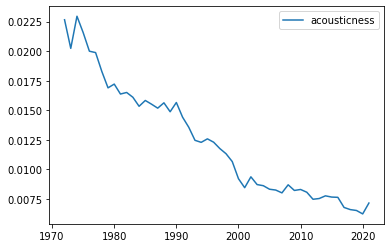

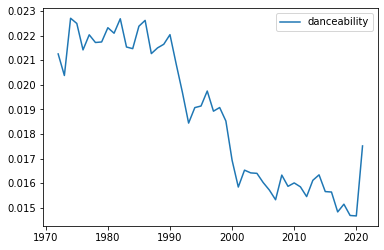

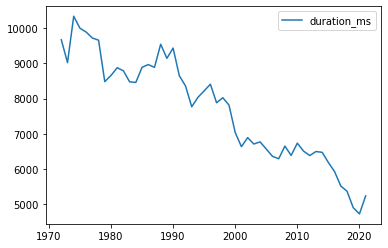

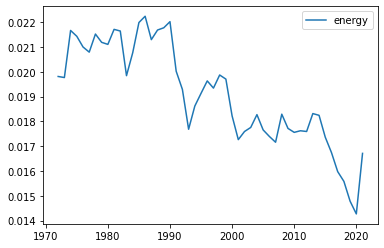

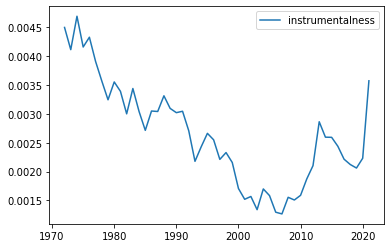

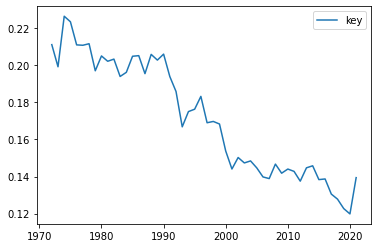

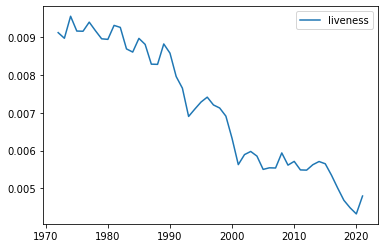

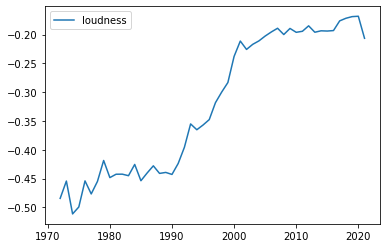

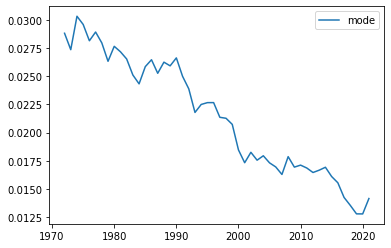

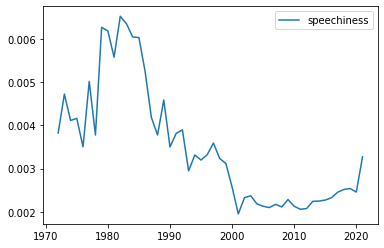

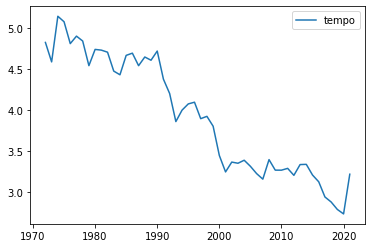

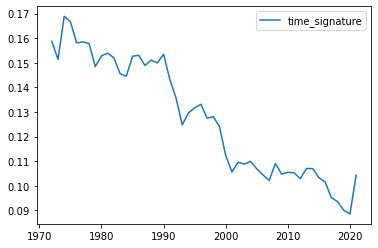

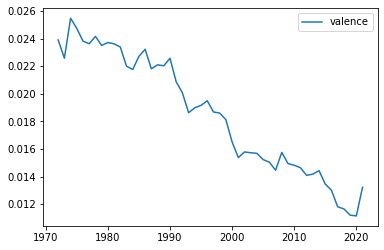

In [60]:
for col in technical_columns:
  #  col = technical_columns[0]
#plt.fill_between(dfp['min_'+col],dfp['max_'+col])
    plt.plot(dfp['wavg_'+col],label=col)
    plt.legend()
    plt.show()


